<a href="https://colab.research.google.com/github/Tien84/BitcoinPrediction/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras

In [ ]:
!pip install matplotlib

In [ ]:
!pip install sklearn

In [ ]:
!pip install tensorflow

In [3]:
from google.colab import drive
drive.mount('/content/driver')

Mounted at /content/driver


In [19]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Flatten, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('/content/driver/My Drive/DataSet/DataBitcoin.csv')
#data= data[::-1] 
data.index.freg='Date'
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-10-27,285.181000,296.212006,285.007996,293.787994,293.787994,46331800
1,2015-10-28,293.703003,306.330994,293.703003,304.618011,304.618011,50808100
2,2015-10-29,304.324005,318.170013,301.822998,313.855011,313.855011,64495900
3,2015-10-30,313.942993,334.169006,313.940002,328.015015,328.015015,78305000
4,2015-10-31,328.511993,332.777008,309.251007,314.165985,314.165985,48598100
...,...,...,...,...,...,...,...
2553,2022-10-23,19207.734375,19646.652344,19124.197266,19567.007813,19567.007813,22128794335
2554,2022-10-24,19567.769531,19589.125000,19206.324219,19345.572266,19345.572266,30202235805
2555,2022-10-25,19344.964844,20348.412109,19261.447266,20095.857422,20095.857422,47761524910
2556,2022-10-26,20092.236328,20938.134766,20076.117188,20770.441406,20770.441406,58895950537


In [5]:
data.head(), data.tail()

(         Date        Open        High         Low       Close   Adj Close  \
 0  2015-10-27  285.181000  296.212006  285.007996  293.787994  293.787994   
 1  2015-10-28  293.703003  306.330994  293.703003  304.618011  304.618011   
 2  2015-10-29  304.324005  318.170013  301.822998  313.855011  313.855011   
 3  2015-10-30  313.942993  334.169006  313.940002  328.015015  328.015015   
 4  2015-10-31  328.511993  332.777008  309.251007  314.165985  314.165985   
 
      Volume  
 0  46331800  
 1  50808100  
 2  64495900  
 3  78305000  
 4  48598100  ,
             Date          Open          High           Low         Close  \
 2553  2022-10-23  19207.734375  19646.652344  19124.197266  19567.007813   
 2554  2022-10-24  19567.769531  19589.125000  19206.324219  19345.572266   
 2555  2022-10-25  19344.964844  20348.412109  19261.447266  20095.857422   
 2556  2022-10-26  20092.236328  20938.134766  20076.117188  20770.441406   
 2557  2022-10-27  20775.890625  20849.746094  20684.7

In [6]:
open_price = data.iloc[:,1:2]
#open_price = data.iloc[:,2:2]
train_set = open_price[:1791].values
test_set = open_price[1791:].values
print("Train size: ",train_set.shape)
print("Test size:",test_set.shape)

Train size:  (1791, 1)
Test size: (767, 1)


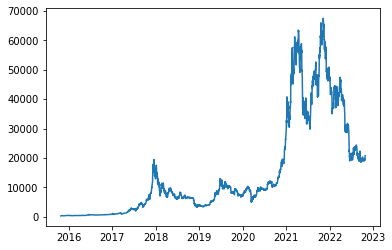

In [7]:
dates = pd.to_datetime(data['Date'])
plt.plot_date(dates,open_price, fmt='-')
plt.savefig("BTC_hinh.png")

In [43]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [41]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')

In [42]:
data = pd.DataFrame(json.loads(res.content)['Data'])
data = data.set_index('time')
data.index = pd.to_datetime(data.index, unit='s')
target_col = 'close'

In [26]:
def train_test_split(data, test_size=0.2):
    split_row = len(data) - int(test_size * len(data))
    train_data = data.iloc[:split_row]
    test_data = data.iloc[split_row:]
    return train_data, test_data

In [9]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [11]:
train, test = train_test_split(data, test_size=0.2)

In [27]:
def normalise_zero_base(data):
    return data / data.iloc[0] - 1

def normalise_min_max(data):
    return (data - data.min()) / (data.max() - data.min())

In [28]:
def extract_window_data(data, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(data) - window_len):
        tmp = data[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [29]:
def prepare_data(data, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(data, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [34]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model


In [35]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [44]:
train, test, X_train, X_test, y_train, y_test = prepare_data( data, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


TypeError: ignored

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)